In [1]:
import pandas as pd

In [3]:
df = pd.read_parquet("daily_weather_data_zip_centers.parquet")

In [7]:
df["above30"] = df.TmaxD > 30

In [9]:
count_above_30_per_locality = df.groupby([df.time.dt.year, df.ZIP4]).above30.sum()

In [13]:
count_above_30_per_locality = count_above_30_per_locality.reset_index()

In [15]:
count_above_30_per_locality

time  ZIP4  above30
0       1980  1000        0
1       1980  1003        0
2       1980  1004        0
3       1980  1005        0
4       1980  1006        0
...      ...   ...      ...
140531  2023  9652        7
140532  2023  9655        7
140533  2023  9656        1
140534  2023  9657        4
140535  2023  9658        0

[140536 rows x 3 columns]

In [14]:
import plotly.express as px

In [20]:
large_color_palette = px.colors.qualitative.Alphabet + px.colors.qualitative.Bold + px.colors.qualitative.Dark24 + px.colors.qualitative.Light24

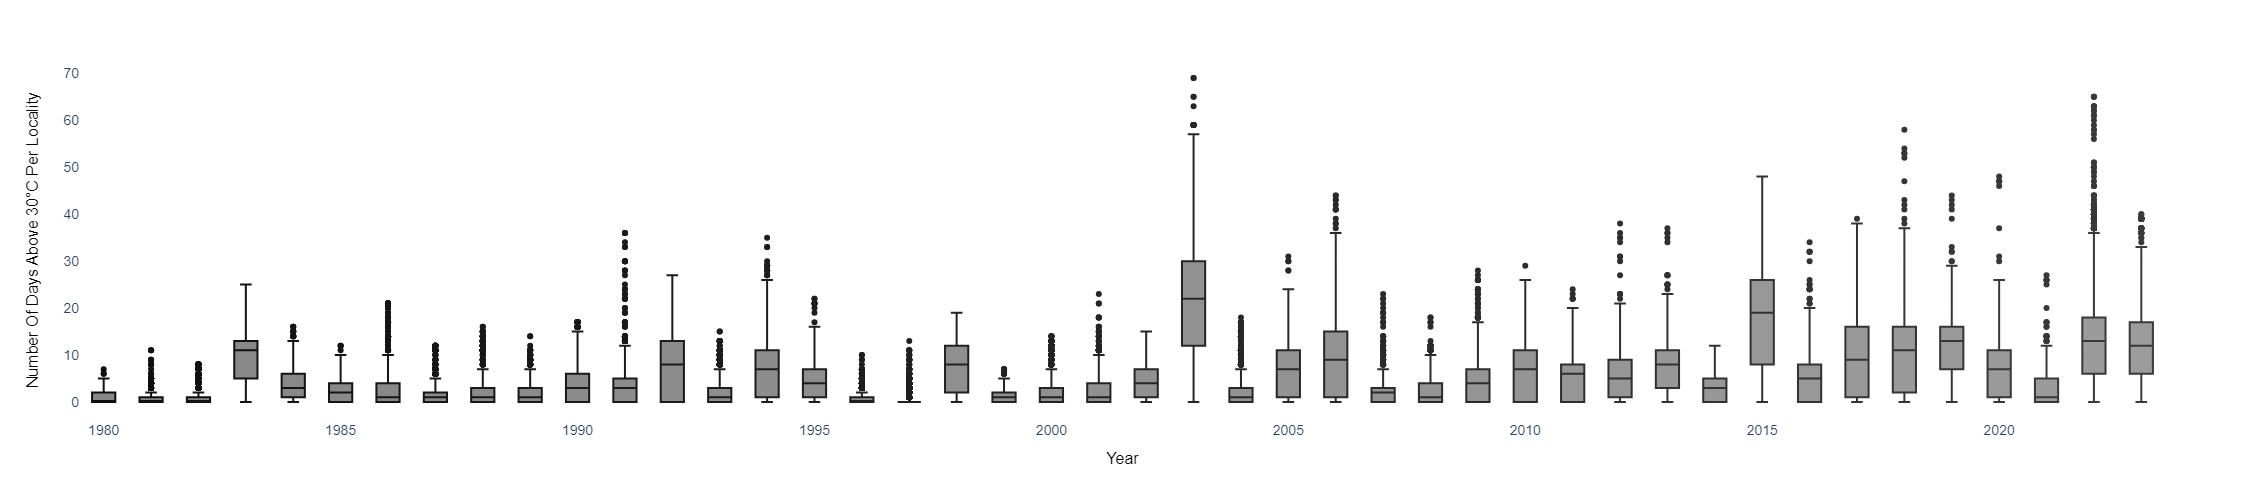

In [40]:
dark_color_scale = [
    f"#{hex(10 + i)[2:].zfill(2)}{hex(10 + i)[2:].zfill(2)}{hex(10 + i)[2:].zfill(2)}"
    for i in range(5, 50)  # Adjusting the range to create much darker shades (e.g., starting from 0x0A to 0x31)
]

# Create the box plot using the dark color scheme
fig = px.box(count_above_30_per_locality, x="time", y="above30", color="time",
             color_discrete_sequence=dark_color_scale)

# Update layout as per the specifications
fig.update_layout(
    showlegend=False,  # Remove legend
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper background to transparent
    xaxis_title=dict(text="Year", font=dict(color="black", family="Arial", size=16)),  # Customizing x-axis title
    yaxis_title=dict(text="Number Of Days Above 30°C Per Locality", font=dict(color="black", family="Arial", size=16)),  # Customizing y-axis title
    height=500,  # Set the figure height
    width=1000,  # Set the figure width
    font=dict(size=14, family="Arial")  # General font settings
)

fig.show()

# Saving the figure with higher DPI and transparent background
fig.write_image("box_plot_transparent_high_dpi.png", scale=3)

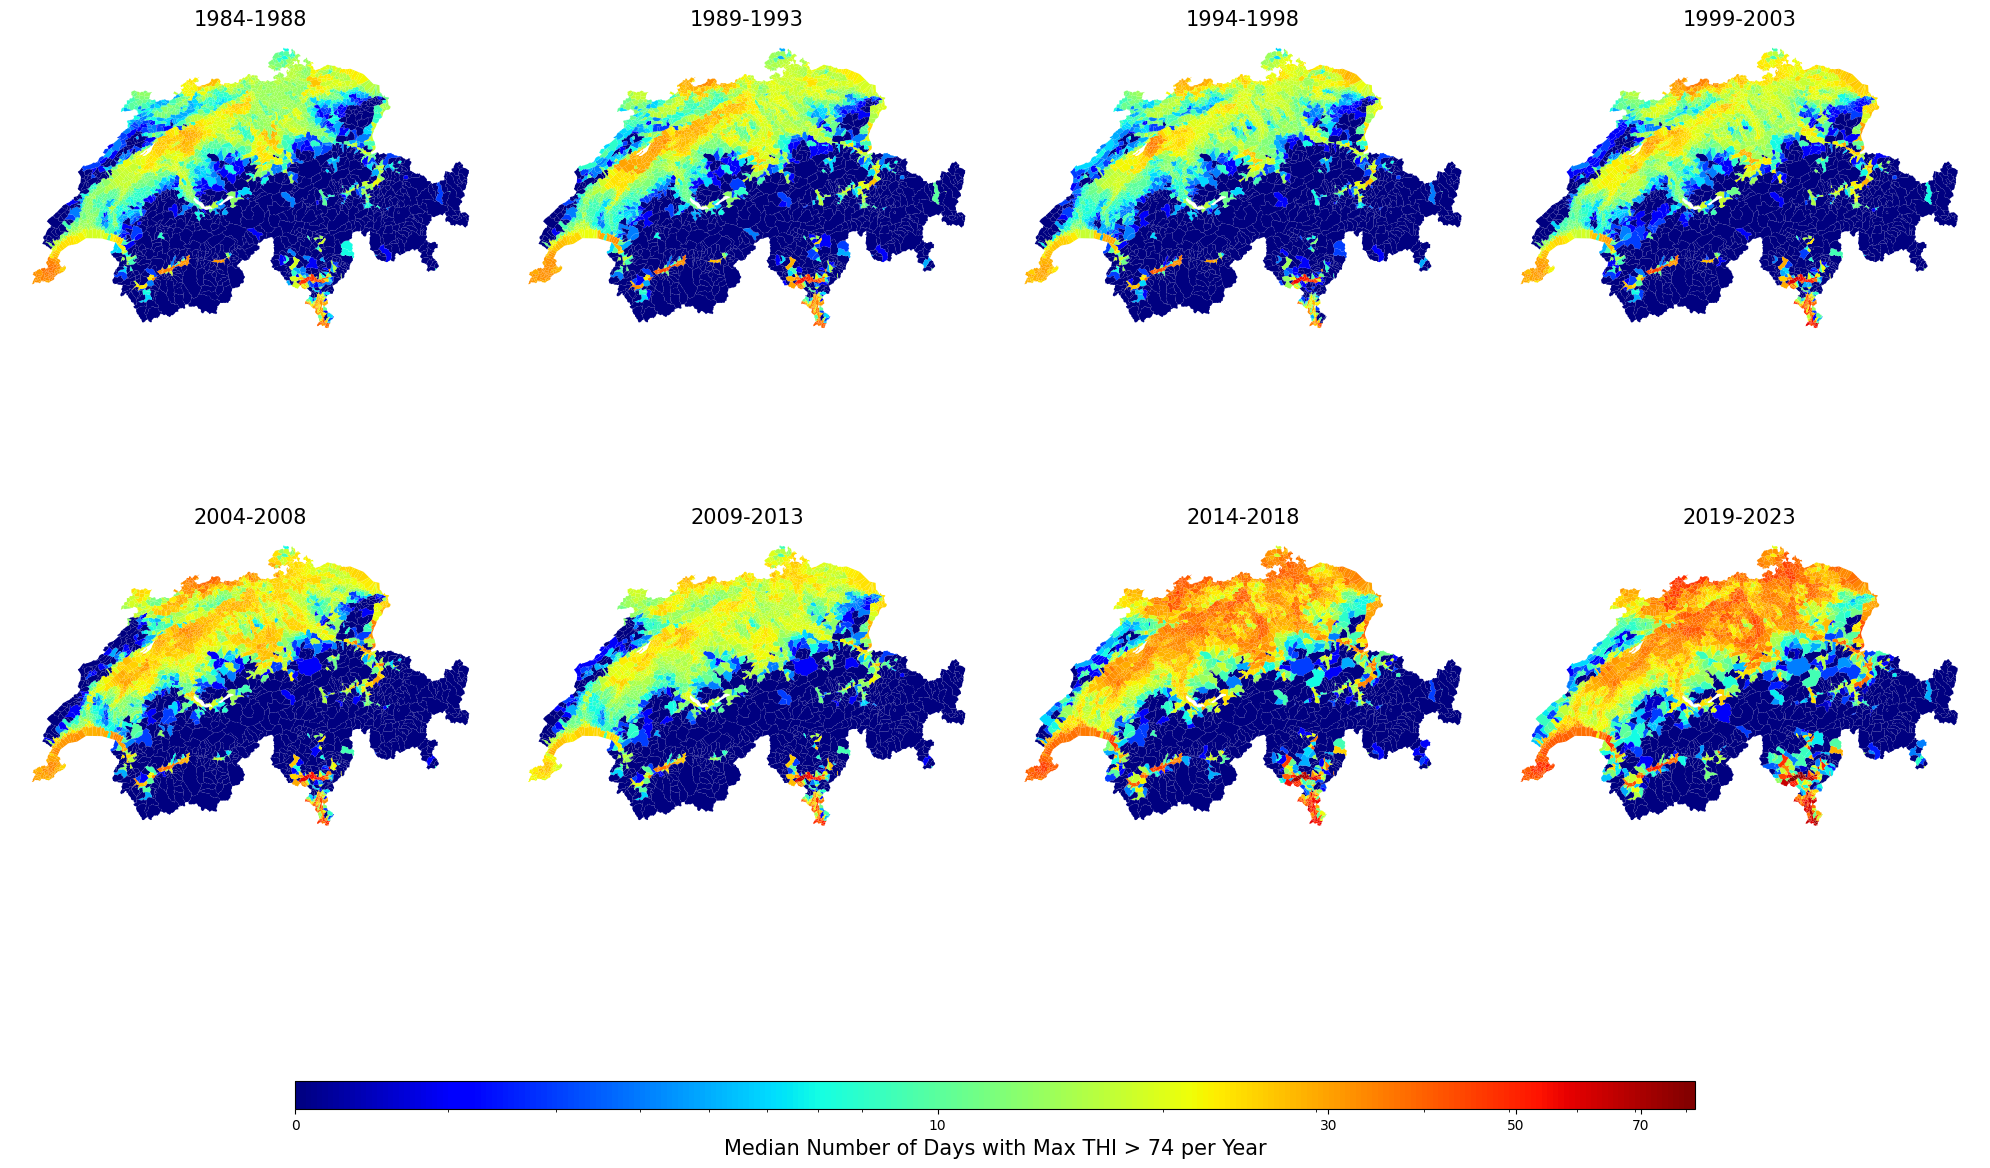

In [32]:
import pandas as pd
import geopandas as gp
gp.options.io_engine = "pyogrio"
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.colors as mcolors

t = 74
df = pd.read_parquet("/home/aschneuwl/workspace/agecon-thesis/notebooks/00_preprocessing/daily_weather_data_zip_centers.parquet")
localities_swiss = gp.read_parquet("/mnt/wks3/aschneuwl/workspace/data/preprocessed/geo/swiss_localities_with_altitudes.parquet")

# Create year column
df.loc[:, "year"] = df.time.dt.year

# Function to process data for a given year range
def process_data(start_year, end_year):
    data = df[(df["year"] >= start_year-1) & (df["year"] < end_year+1)].groupby(["ZIP4", "year"])["thi_max"].apply(lambda x: (x > t).sum()).reset_index().groupby("ZIP4").thi_max.median().reset_index()
    data.loc[:,"thi_max"] = data["thi_max"].apply(lambda x: x + 1)
    return localities_swiss.merge(data, on="ZIP4")

# Generate data for each 5-year period
data_periods = [process_data(start_year, start_year + 5) for start_year in range(1984, 2024, 5)]

/tmp/ipykernel_985360/117911171.py:29: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



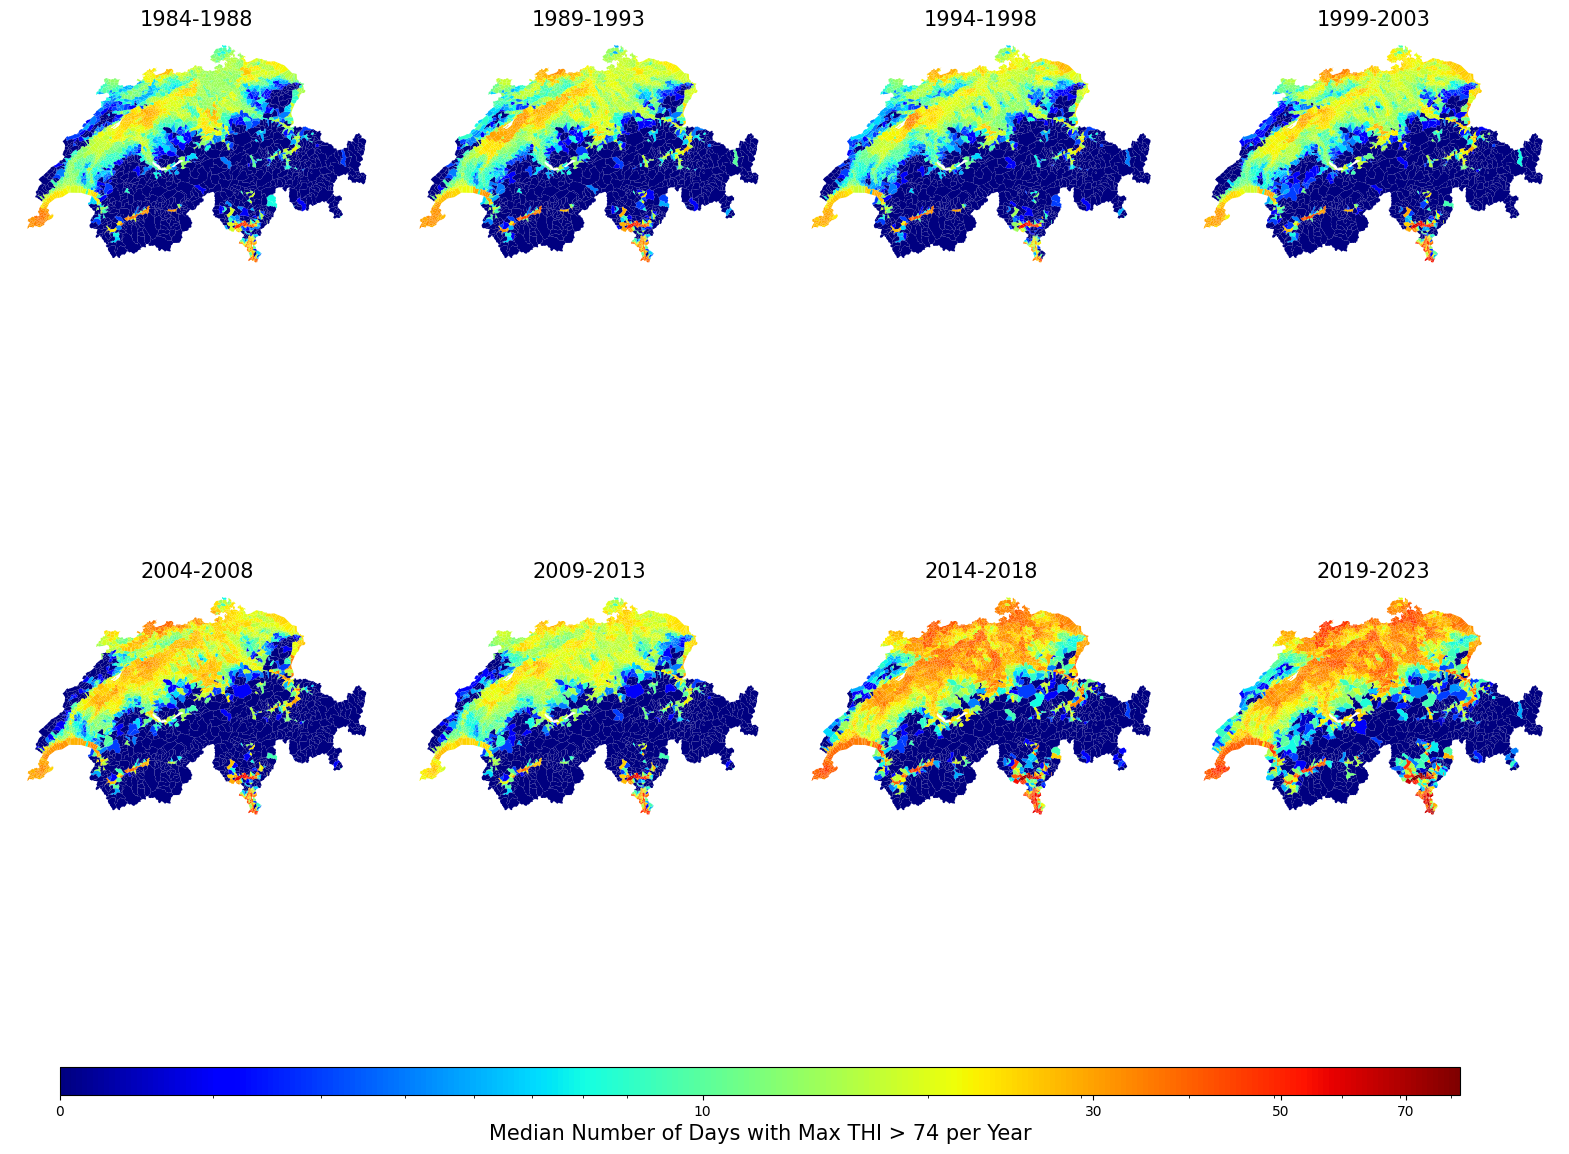

In [41]:
# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 14), gridspec_kw={'hspace': 0.05, 'wspace': 0.05})


axs = axs.flatten()

# Set common color scale
vmin = min([data['thi_max'].min() for data in data_periods])
vmax = max([data['thi_max'].max() for data in data_periods])
norm = mcolors.LogNorm(vmin=vmin + 1, vmax=vmax)

# Plot each data period
for i, ax in enumerate(axs):
    if i < len(data_periods):
        data_periods[i].plot(ax=ax, column="thi_max", legend=False, cmap='jet', vmin=vmin, vmax=vmax, norm=norm)
        ax.set_title(f'{1984 + i*5}-{1988 + i*5}', fontsize=15)
    else:
        ax.axis('off')
    
    # Remove axes and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add a common colorbar
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
sm._A = []
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([2, 11, 31, 51, 71])
cbar.set_ticklabels([0, 10, 30, 50, 70])
cbar.set_label(f'Median Number of Days with Max THI > {t} per Year', fontsize=15)

# Save or display the figure
#save_fpath_pdf = Path(__file__).parent.resolve() / Path(f"thi_above_{t}.pdf")
#save_fpath_png = Path(__file__).parent.resolve() / Path(f"thi_above_{t}.png")
#fig.savefig(save_fpath_pdf, format='pdf', bbox_inches='tight')
#fig.savefig(save_fpath_png, format='png', bbox_inches='tight')

plt.show()

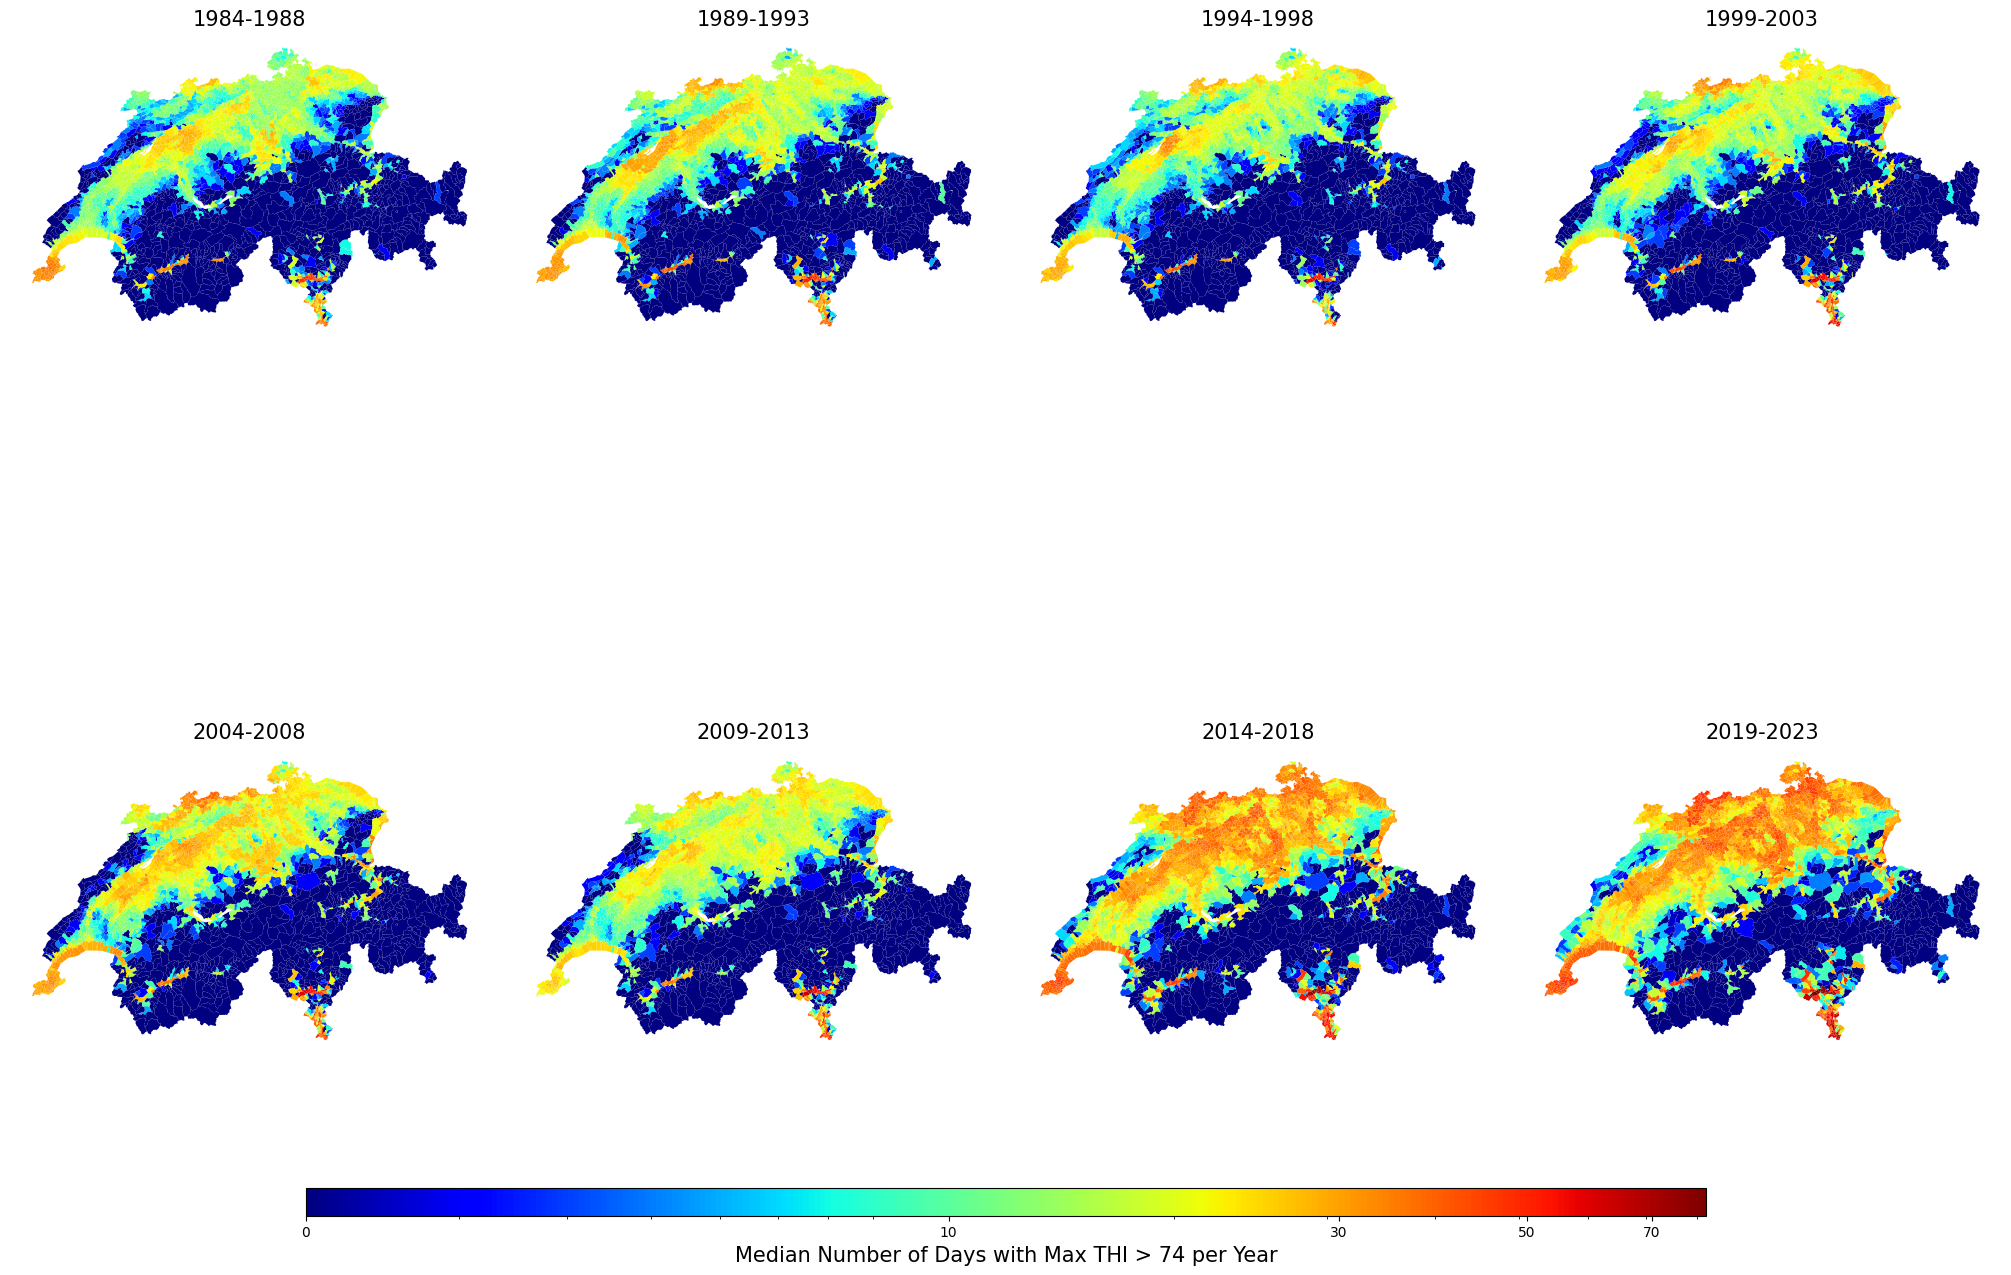

In [43]:
# Create subplots with constrained layout
fig, axs = plt.subplots(2, 4, figsize=(20, 14), gridspec_kw={'hspace': 0.05, 'wspace': 0.05}, constrained_layout=True)

axs = axs.flatten()

# Set common color scale
vmin = min([data['thi_max'].min() for data in data_periods])
vmax = max([data['thi_max'].max() for data in data_periods])
norm = mcolors.LogNorm(vmin=vmin + 1, vmax=vmax)

# Plot each data period
for i, ax in enumerate(axs):
    if i < len(data_periods):
        data_periods[i].plot(ax=ax, column="thi_max", legend=False, cmap='jet', vmin=vmin, vmax=vmax, norm=norm)
        ax.set_title(f'{1984 + i*5}-{1988 + i*5}', fontsize=15)
    else:
        ax.axis('off')
    
    # Remove axes and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add a common colorbar
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm._A = []
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([2, 11, 31, 51, 71])
cbar.set_ticklabels([0, 10, 30, 50, 70])
cbar.set_label(f'Median Number of Days with Max THI > {t} per Year', fontsize=15)

# Save or display the figure
#save_fpath_pdf = Path(__file__).parent.resolve() / Path(f"thi_above_{t}.pdf")
#save_fpath_png = Path(__file__).parent.resolve() / Path(f"thi_above_{t}.png")
#fig.savefig(save_fpath_pdf, format='pdf', bbox_inches='tight')
#fig.savefig(save_fpath_png, format='png', bbox_inches='tight')

plt.show()
